# GRU Model for Crypto Price Prediction

**Target**: Predicting whether the crypto price will be higher in 5 days than it is today  
**Method**: Gated Recurrent Unit (GRU) - Recurrent Neural Network with TensorFlow/Keras

## What is GRU?
- **Recurrent architecture**: Processes sequences of data (20-day windows)
- **2 gates**: Update gate and Reset gate for memory control
- **Temporal awareness**: Learns patterns across time (e.g., "prices usually rise 3 days after a drop")
- **Lightweight RNN**: Simpler than LSTM (~35K parameters), faster training
- **Built-in memory**: No need for manual lag features, learns temporal dependencies automatically
- **Data shape**: 3D input (samples, timesteps, features) = (139,766 sequences, 20 days, 68 features)

In [1]:
# standart libraries
import pandas as pd
import numpy as np
import random
import datetime
from pathlib import Path 

# project specific libraries
import tensorflow as tf

# random seeds for reproducibility e.g. initialisation of weights in NN
SEED = 42  # Changed from 101 to match script
tf.random.set_seed(SEED) #weight initialization, dropout masks, batch shuffling
np.random.seed(SEED) #array operations, train_test_split, data transformations
random.seed(SEED) #random(), shuffle(), choice()

# Visualization
import matplotlib.pyplot as plt

# Modelling
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# MLflow for experiment tracking
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("gru_experiment")

2025/11/16 17:21:38 INFO mlflow.tracking.fluent: Experiment with name 'gru_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://time-series-dvc-storage/mlflow/3', creation_time=1763310098625, experiment_id='3', last_update_time=1763310098625, lifecycle_stage='active', name='gru_experiment', tags={}>

In [2]:
# load data
DATA_PATH = Path("/Users/ina/Documents/spicedAcademy/time_series_project/data/final_data/20251115_dataset_crp.csv")

# Error handling for file operations
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df_gru = pd.read_csv(DATA_PATH)

In [3]:
# Train-Validation-Test Split (70%-15%-15% temporal split)
split_date_train = "2024-07-01"  # Training until this date
split_date_val = "2024-10-01"    # Validation from here
split_date_test = "2024-10-01"   # Fixed: removed 3-month gap

#parameter
x_cols_to_drop = ['ticker', 'date', 'future_5_close_higher_than_today', 'future_10_close_higher_than_today',
"future_5_close_lower_than_today", "future_10_close_lower_than_today", "higher_close_today_vs_future_5_close", 
"higher_close_today_vs_future_10_close", "lower_close_today_vs_future_5_close", "lower_close_today_vs_future_10_close"]

df_train = df_gru[df_gru['date'] < split_date_train].copy()
df_val = df_gru[(df_gru['date'] >= split_date_train) & (df_gru['date'] < split_date_val)].copy()
df_test = df_gru[df_gru['date'] >= split_date_test].copy()

print(f"\nTraining set: {len(df_train)} samples")
print(f"Validation set: {len(df_val)} samples")
print(f"Test set: {len(df_test)} samples")
print(f"Train up to date: {df_train['date'].max()}")
print(f"Validation from date: {df_val['date'].min()} to {df_val['date'].max()}")
print(f"Test from date: {df_test['date'].min()}")


Training set: 142034 samples
Validation set: 9543 samples
Test set: 49396 samples
Train up to date: 2024-06-30 00:00:00+00:00
Validation from date: 2024-07-01 00:00:00+00:00 to 2024-09-30 00:00:00+00:00
Test from date: 2024-10-01 00:00:00+00:00


In [4]:
# Prepare features and targets - KEEP 'ticker' and 'date' for sequence creation
# For GRU, we need these columns to:
# - Sort data chronologically (date)
# - Create sequences per cryptocurrency (ticker)

# Features: exclude targets but KEEP 'ticker' and 'date' temporarily
feature_cols = [col for col in df_train.columns 
                if col not in ['future_5_close_higher_than_today', 'future_10_close_higher_than_today',
                              'future_5_close_lower_than_today', 'future_10_close_lower_than_today',
                              'higher_close_today_vs_future_5_close', 'higher_close_today_vs_future_10_close',
                              'lower_close_today_vs_future_5_close', 'lower_close_today_vs_future_10_close']]

X_train = df_train[feature_cols].copy()
y_train = df_train["future_5_close_higher_than_today"].values

X_val = df_val[feature_cols].copy()
y_val = df_val["future_5_close_higher_than_today"].values

X_test = df_test[feature_cols].copy()
y_test = df_test["future_5_close_higher_than_today"].values

# Scaling - GLOBAL scaling (all tickers together, simpler than per-ticker)
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Prepare data for scaling (exclude ticker and date from scaling)
cols_to_scale = [col for col in X_train.columns if col not in ['ticker', 'date']]

# Fit on training data ONLY (avoid leakage)
X_train_scaled_vals = scaler_X.fit_transform(X_train[cols_to_scale])
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Transform validation and test data
X_val_scaled_vals = scaler_X.transform(X_val[cols_to_scale])
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

X_test_scaled_vals = scaler_X.transform(X_test[cols_to_scale])
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print(f"   Features shape: {X_train_scaled_vals.shape}")
print(f"   Target shape: {y_train_scaled.shape}")
print(f"   Note: 'ticker' and 'date' kept for sequence creation")

   Features shape: (142034, 68)
   Target shape: (142034,)
   Note: 'ticker' and 'date' kept for sequence creation


In [5]:
# Create sequences for GRU (convert 2D to 3D data)
# GRU needs: (samples, timesteps, features) instead of (samples, features)

def create_sequences(X_data, y_data, df, look_back=20):
    """Create sliding window sequences for each crypto separately
    
    Returns sequences AND original indices for alignment
    """
    
    X_sequences = []
    y_sequences = []
    original_indices = []  # Track which original row each sequence comes from
    
    # Process each cryptocurrency separately
    for ticker in df['ticker'].unique():
        # Get data for this crypto only
        mask = df['ticker'] == ticker
        ticker_indices = df[mask].index.values  # Original dataframe indices
        crypto_X = X_data[mask]
        crypto_y = y_data[mask]
        crypto_dates = df.loc[mask, 'date'].values
        
        # Sort by date (important for time series!)
        order = np.argsort(crypto_dates)
        crypto_X = crypto_X[order]
        crypto_y = crypto_y[order]
        ticker_indices = ticker_indices[order]
        
        # Create sliding windows
        for i in range(len(crypto_X) - look_back):
            X_sequences.append(crypto_X[i:i+look_back])  # Past days
            y_sequences.append(crypto_y[i + look_back])  # Future target
            original_indices.append(ticker_indices[i + look_back])  # Track original index
    
    return np.array(X_sequences), np.array(y_sequences), np.array(original_indices)


# Settings
look_back = 20  # Use past 20 days to predict

# Create sequences for all splits (now with indices)
print("Creating sequences...")
X_train_seq, y_train_seq, train_indices = create_sequences(X_train_scaled_vals, y_train_scaled, X_train, look_back)
X_val_seq, y_val_seq, val_indices = create_sequences(X_val_scaled_vals, y_val_scaled, X_val, look_back)
X_test_seq, y_test_seq, test_indices = create_sequences(X_test_scaled_vals, y_test_scaled, X_test, look_back)

# Get dimensions for model
n_features = X_train_seq.shape[2]

print(f"\nShape: {X_train_seq.shape}")
print(f"   {X_train_seq.shape[0]} sequences")
print(f"   {look_back} days look-back")
print(f"   {n_features} features")
print(f"   Indices tracked for alignment")

Creating sequences...

Shape: (139766, 20, 68)
   139766 sequences
   20 days look-back
   68 features
   Indices tracked for alignment


In [6]:
# MODEL ARCHITECTURE - GRU for Time Series Prediction

from tensorflow.keras.layers import Input, Dropout

# Hyperparameters
gru_units = 64
gru_dropout = 0.3
use_second_gru = True
dense_units = 32
dense_dropout = 0.2
learning_rate = 0.0001
L2_regularization = 0.0001

# Build model based on configuration
if use_second_gru:
    model_gru = Sequential([
        Input(shape=(look_back, n_features)),
        
        # First GRU layer
        GRU(gru_units, 
            return_sequences=True,  # MUST be True for stacked GRU
            kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
            name='gru_layer_1'),
        Dropout(gru_dropout, name='dropout_1'),
        
        # Second GRU layer
        GRU(gru_units // 2, 
            return_sequences=False,  # False for last GRU layer
            kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
            name='gru_layer_2'),
        Dropout(gru_dropout, name='dropout_2'),
        
        # Output layer
        Dense(1, activation='linear', name='output')
    ])
else:
    model_gru = Sequential([
        Input(shape=(look_back, n_features)),
        
        # Single GRU layer
        GRU(gru_units, 
            return_sequences=False,  # Only output last timestep
            kernel_regularizer=tf.keras.regularizers.l2(L2_regularization),
            name='gru_layer'),
        Dropout(gru_dropout, name='dropout'),
        
        # Output layer
        Dense(1, activation='linear', name='output')
    ])

# Compile model
model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mae',
    metrics=['mae', 'mse']
)

print("GRU Model Architecture:")
model_gru.summary()

GRU Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_layer_1 (GRU)               │ (None, 20, 64)         │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_2 (GRU)               │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,169 (137.38 KB)

 Trainable params: 35,169 (137.38 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# TRAIN GRU MODEL

# Training parameters
epochs = 100
batch_size = 128  # Smaller batch size for GRU (time series, more memory intensive)
patience = 10

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

# Train model with sequences
history = model_gru.fit(
    X_train_seq, y_train_seq,  # 3D sequences
    validation_data=(X_val_seq, y_val_seq),  # Use validation se
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.7804 - mae: 0.7633 - mse: 1.0589 - val_loss: 0.7645 - val_mae: 0.7486 - val_mse: 0.9574
Epoch 2/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.7406 - mae: 0.7251 - mse: 0.9805 - val_loss: 0.7656 - val_mae: 0.7510 - val_mse: 0.9627
Epoch 3/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.7296 - mae: 0.7152 - mse: 0.9589 - val_loss: 0.7684 - val_mae: 0.7547 - val_mse: 0.9734
Epoch 4/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.7205 - mae: 0.7071 - mse: 0.9424 - val_loss: 0.7734 - val_mae: 0.7605 - val_mse: 0.9895
Epoch 5/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.7117 - mae: 0.6990 - mse: 0.9258 - val_loss: 0.7706 - val_mae: 0.7583 - val_mse: 0.9839
Epoch 6/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.7036 - mae: 0.6914 - mse: 0.9095 - val_loss: 0.7563 - val_mae: 0.7445 - val_mse: 0.9526
Epoch 7/100
1092/1092 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.695

In [8]:
# Training metrics
mae_train = history.history['mae'][-1]
mse_train = history.history['mse'][-1]
print("Train Set Performance:")
print(f"   MAE:  {mae_train:.4f}")
print(f"   MSE:  {mse_train:.4f}")

val_mae = history.history['val_mae'][-1]
val_mse = history.history['val_mse'][-1]
print("\nValidation Set Performance:")
print(f"   MAE:  {val_mae:.4f}")
print(f"   MSE:  {val_mse:.4f}")

Train Set Performance:
   MAE:  0.5950
   MSE:  0.7154

Validation Set Performance:
   MAE:  0.7431
   MSE:  0.9384


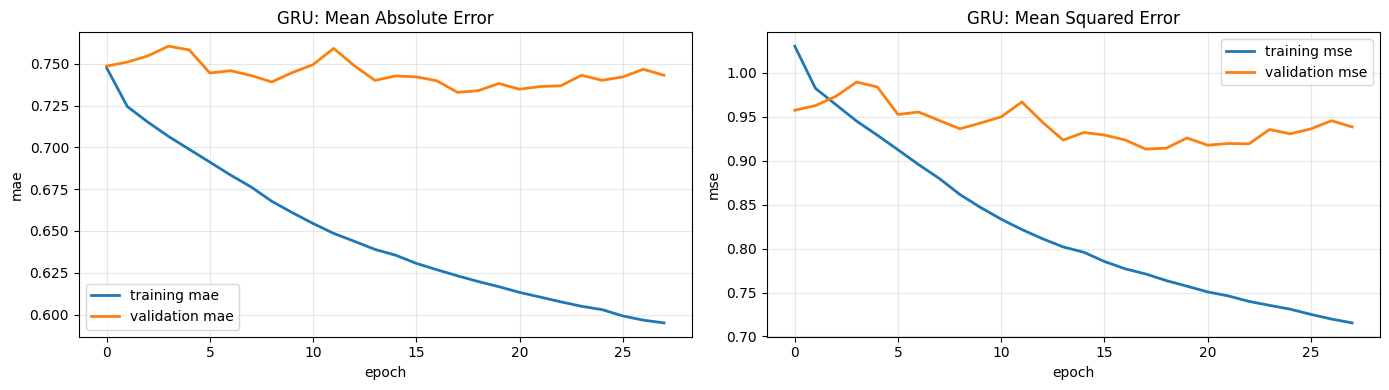

In [9]:
# Visualize training history - GRU
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# MAE
axes[0].plot(history.history['mae'], label='training mae', linewidth=2)
axes[0].plot(history.history['val_mae'], label='validation mae', linewidth=2)
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('mae')
axes[0].set_title('GRU: Mean Absolute Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MSE
axes[1].plot(history.history['mse'], label='training mse', linewidth=2)
axes[1].plot(history.history['val_mse'], label='validation mse', linewidth=2)
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('mse')
axes[1].set_title('GRU: Mean Squared Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Evaluate model on test set
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_scaled = model_gru.predict(X_test_seq)

# Metrics on scaled data
mae = mean_absolute_error(y_test_seq, y_pred_scaled)
mse = mean_squared_error(y_test_seq, y_pred_scaled)

print("Test Set Performance (Scaled Data):")
print(f"   MAE:  {mae:.4f}")
print(f"   MSE:  {mse:.4f}")

1460/1460 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Test Set Performance (Scaled Data):
   MAE:  0.8311
   MSE:  1.2173


In [11]:
# INVERSE TRANSFORM - Convert predictions back to original scale
# Option B: Align with original data using tracked indices

# Inverse transform predictions
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Get actual original values using the tracked indices
# test_indices tells us which rows from df_test each prediction corresponds to
y_test_original = df_test.loc[test_indices, 'future_5_close_higher_than_today'].values

# Calculate metrics on ORIGINAL scale
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)

print("Test Set Performance (Original Scale):")
print(f"   MAE:  {mae:.4f} percentage points")
print(f"   MSE:  {mse:.4f}")
print(f"\nNote: {len(y_pred_original)} predictions aligned with original data using indices")

Test Set Performance (Original Scale):
   MAE:  9.4398 percentage points
   MSE:  157.0424

Note: 46706 predictions aligned with original data using indices


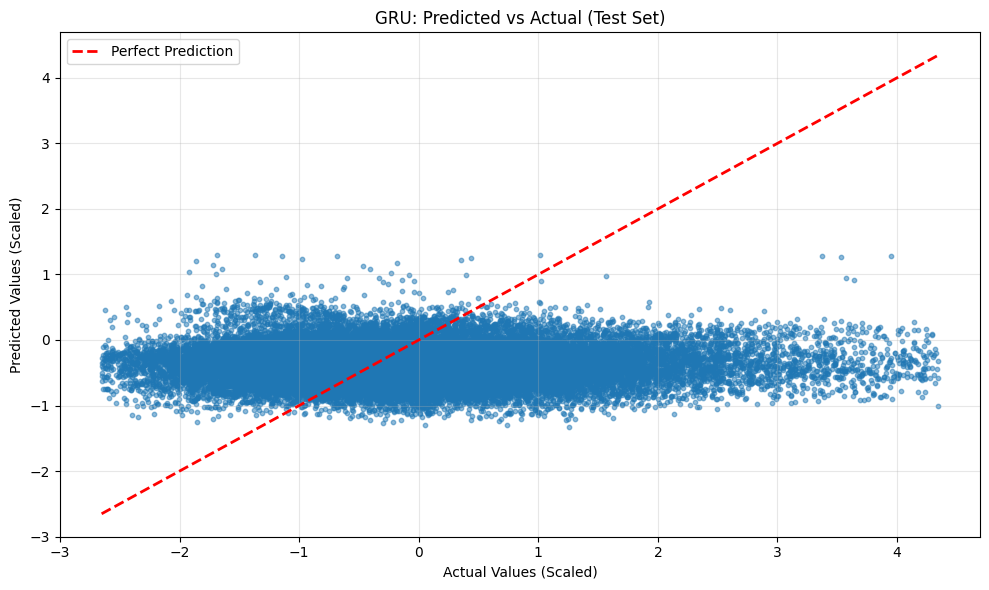

In [12]:
# Visualize: Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_seq, y_pred_scaled, alpha=0.5, s=10)
plt.plot([y_test_seq.min(), y_test_seq.max()], 
         [y_test_seq.min(), y_test_seq.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values (Scaled)')
plt.ylabel('Predicted Values (Scaled)')
plt.title('GRU: Predicted vs Actual (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

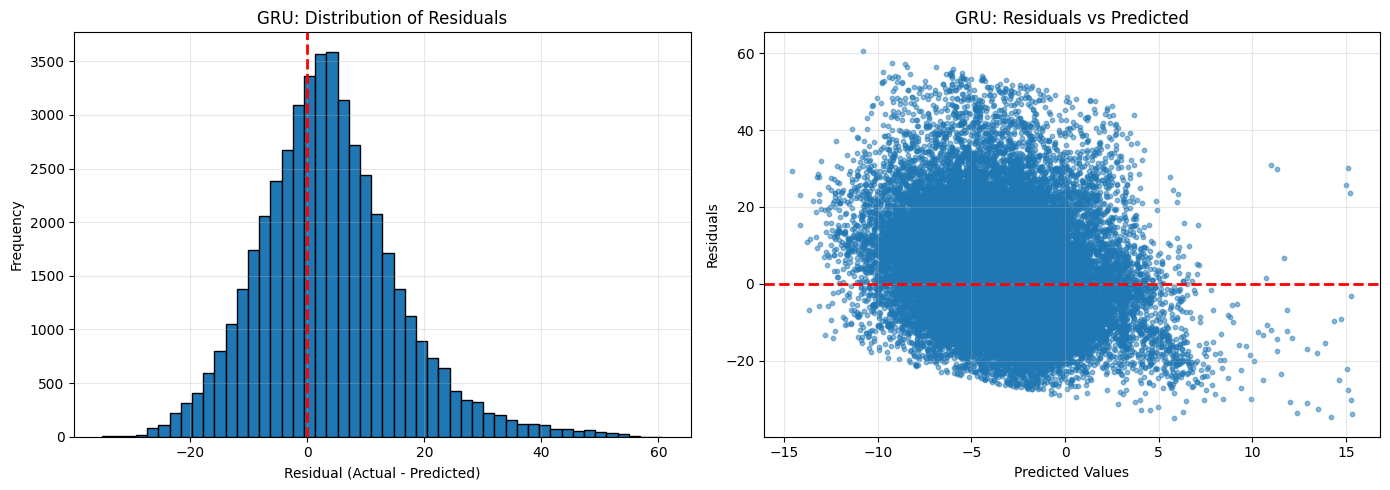

Residual Stats:
   Mean: 3.7207
   Std:  11.9666
   Min:  -35.0556
   Max:  60.7045


In [13]:
# Visualize: Residuals Analysis - GRU
residuals = y_test_original - y_pred_original

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals histogram
axes[0].hist(residuals, bins=50, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residual (Actual - Predicted)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('GRU: Distribution of Residuals')
axes[0].grid(True, alpha=0.3)

# Residuals vs Predicted
axes[1].scatter(y_pred_original, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('GRU: Residuals vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Stats:")
print(f"   Mean: {residuals.mean():.4f}")
print(f"   Std:  {residuals.std():.4f}")
print(f"   Min:  {residuals.min():.4f}")
print(f"   Max:  {residuals.max():.4f}")

In [14]:
# training set metrics from the last epoch

mae_train = history.history['mae'][-1] #last epoch
mse_train = history.history['mse'][-1]
print("Train Set Performance:")
print(f"   mae:  {mae_train:.4f}")
print(f"   mse:  {mse_train:.4f}")


# validation set metrics from the last epoch
val_mae = history.history['val_mae'][-1]
val_mse = history.history['val_mse'][-1]
print("\n Validation Set Performance:")
print(f"   mae:  {val_mae:.4f}")
print(f"   mse:  {val_mse:.4f}")

Train Set Performance:
   mae:  0.5950
   mse:  0.7154

 Validation Set Performance:
   mae:  0.7431
   mse:  0.9384


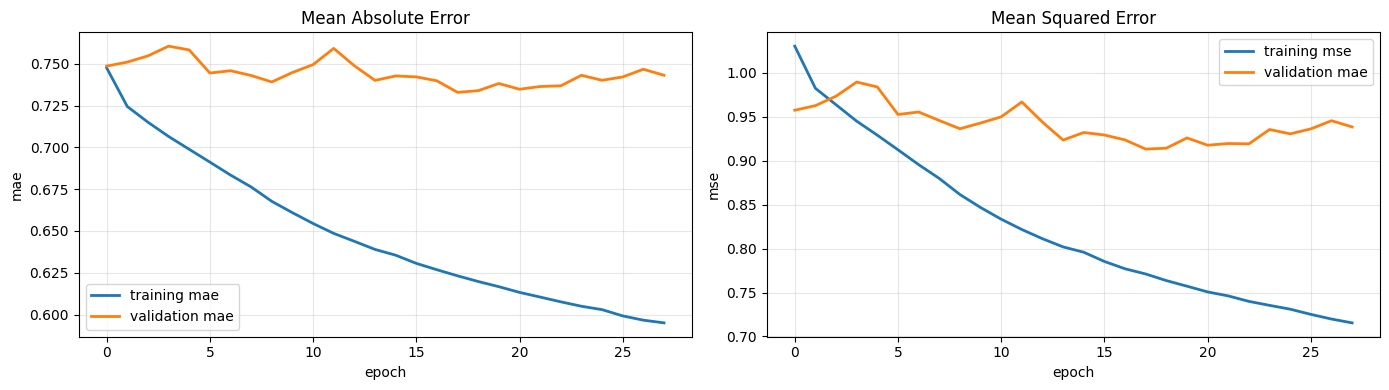

In [15]:
# visualize training history

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# mae
axes[0].plot(history.history['mae'], label='training mae', linewidth=2) #Mean Absolute Error on Training Data Set
axes[0].plot(history.history['val_mae'], label='validation mae', linewidth=2) # Mean Absolute Error on Validation Data Set
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('mae')
axes[0].set_title('Mean Absolute Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#mse
axes[1].plot(history.history['mse'], label='training mse', linewidth=2) #Mean Squared Error on Training Data Set
axes[1].plot(history.history['val_mse'], label='validation mae', linewidth=2) # Mean Squared Error on Validation Data Set
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('mse')
axes[1].set_title('Mean Squared Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred_scaled = model_gru.predict(X_test_seq)
mae = mean_absolute_error(y_test_seq, y_pred_scaled)
mse = mean_squared_error(y_test_seq, y_pred_scaled)
print("Test Set Performance (Scaled Data):")
print(f"   MAE:  {mae:.4f}")
print(f"   MSE:  {mse:.4f}")

1460/1460 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test Set Performance (Scaled Data):
   MAE:  0.8311
   MSE:  1.2173


In [17]:
# INVERSE TRANSFORM back to original scale
y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Calculate metrics on ORIGINAL scale
y_test_original = df_test.loc[test_indices, "future_5_close_higher_than_today"].values
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
print("Test Set Performance (Original Scale):")
print(f"   MAE:  {mae:.4f} percentage points")
print(f"   MSE:  {mse:.4f}")

Test Set Performance (Original Scale):
   MAE:  9.4398 percentage points
   MSE:  157.0424


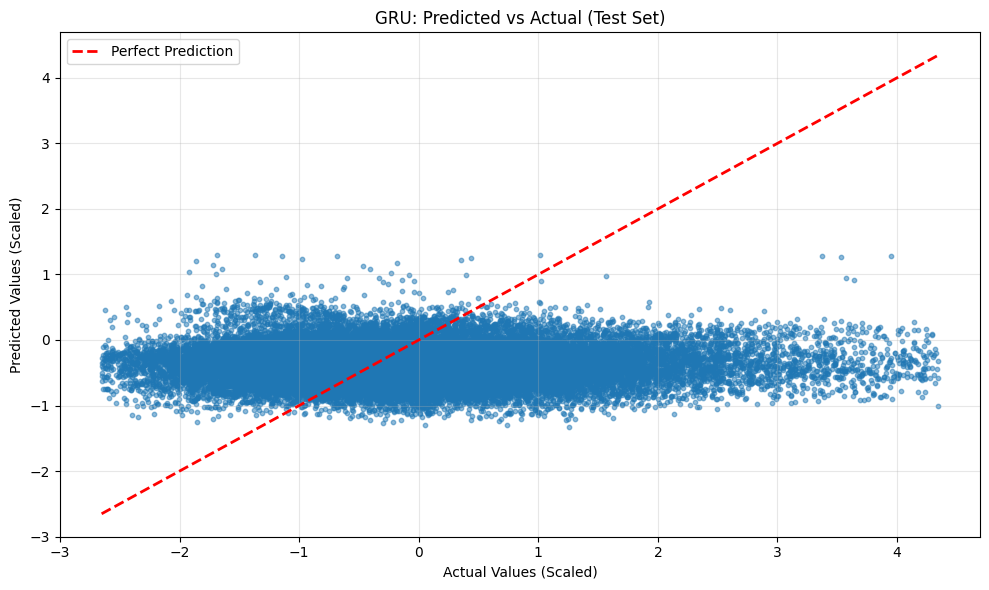

In [18]:
# visualize final prediction - predicted vs. actual

# How well fits the model?
#  The red line = “perfect prediction”. 
#  Points close to the line = good model/prediction.
#  Points scattered widely = bad model/prediction.
#  All points ABOVE the line = model systematically underestimates.
plt.figure(figsize=(10, 6))
plt.scatter(y_test_seq, y_pred_scaled, alpha=0.5, s=10)
plt.plot(
    [y_test_seq.min(), y_test_seq.max()],
    [y_test_seq.min(), y_test_seq.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
plt.xlabel("Actual Values (Scaled)")
plt.ylabel("Predicted Values (Scaled)")
plt.title("GRU: Predicted vs Actual (Test Set)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

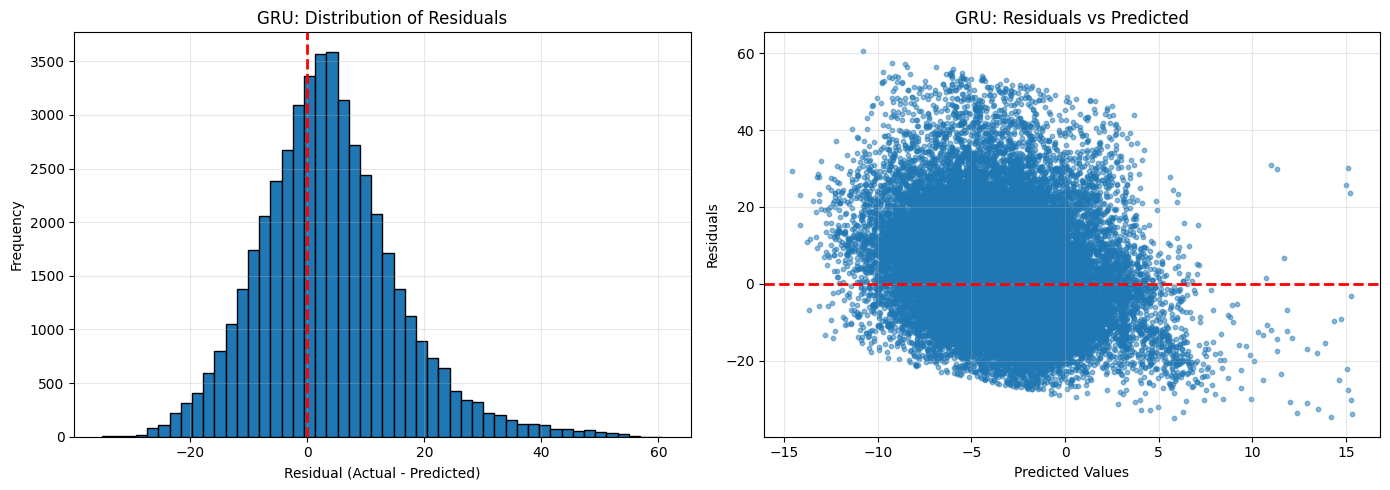

In [19]:
# visualize final prediction - residuals

# Is the error / Are the residuals random?
#  normal distribution around 0 = ideal model
#  distribition shifted = bias, model underestimates?
#  heavy tails = model struggles to handle extreme outliers

residuals = y_test_original - y_pred_original
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(residuals, bins=50, edgecolor="black")
axes[0].axvline(x=0, color="r", linestyle="--", linewidth=2)
axes[0].set_xlabel("Residual (Actual - Predicted)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("GRU: Distribution of Residuals")
axes[0].grid(True, alpha=0.3)
# visualize final prediction - residuals vs. predicted

# Is the error/ Are the residuals constant?
#  constant variance/homoscedastic = good
#  funnel shape/heteroscedastic = bad; errors became greater at high values
#  non-linear pattern/curved shape = model is missing a feature?
axes[1].scatter(y_pred_original, residuals, alpha=0.5, s=10)
axes[1].axhline(y=0, color="r", linestyle="--", linewidth=2)
axes[1].set_xlabel("Predicted Values")
axes[1].set_ylabel("Residuals")
axes[1].set_title("GRU: Residuals vs Predicted")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
model_gru.save('/Users/ina/Documents/spicedAcademy/time_series_project//models/model_gru.keras')

In [21]:
# MLflow Tracking
from sklearn.metrics import mean_absolute_error, mean_squared_error

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

with mlflow.start_run(run_name=f"gru_{timestamp}"):
    mlflow.log_param("gru_units", gru_units)
    mlflow.log_param("gru_dropout", gru_dropout)
    mlflow.log_param("use_second_gru", use_second_gru)
    mlflow.log_param("dense_dropout", dense_dropout)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("L2_regularization", L2_regularization)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("look_back", look_back)
    
    mlflow.log_metric("train_mae", mae_train)
    mlflow.log_metric("train_mse", mse_train)
    mlflow.log_metric("val_mae", val_mae)
    mlflow.log_metric("val_mse", val_mse)
    mlflow.log_metric("test_mae_scaled", mean_absolute_error(y_test_seq, y_pred_scaled))
    mlflow.log_metric("test_mse_scaled", mean_squared_error(y_test_seq, y_pred_scaled))
    mlflow.log_metric("test_mae_original", mean_absolute_error(y_test_original, y_pred_original))
    mlflow.log_metric("test_mse_original", mean_squared_error(y_test_original, y_pred_original))
    
    print(f"\nMLflow run logged with name: gru_{timestamp}")


MLflow run logged with name: gru_20251116_173005
🏃 View run gru_20251116_173005 at: http://127.0.0.1:5001/#/experiments/3/runs/a891114a570a4321961bb7a1dde9f42f
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/3
